<a href="https://colab.research.google.com/github/taljacob2/images_deep_learning/blob/master/TalYacobPython.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialize Notebook

Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [ ]:
from fastai.vision import *
from fastai.metrics import error_rate

In [ ]:
from pathlib import Path

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [ ]:
# bs = 64
bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

# Create Dataset


## Download from [Google Images](https://images.google.com/)

Say you want to identify between the 3 *categories* of *monkey* images:
- Chimpanzee
- Urang Utan
- Baboon

1. Go to [Google Images](https://images.google.com/)
1. **For each** of these *monkey* *categories*:
   1. Search for it.
   1. Download all the images that presented in the page to a `.csv` file, that its first column presents each image's url. To do so:
      1. Press `F12`, to open the *Inspect* view in the browser.
      1. Write in console the below *javascript* code, run it, and rename the downloaded `.csv` file as the *category* you have searched for.
          ```javascript

          /**
           * Gets the image-urls from the given `csvElement`, and outputs
           * to a `.csv` file, with titles as its first row.
           * 
           * @param {HTMLCollectionOf<Element>} csvElement The element of
           *                                    the `.csv` within this
           *                                    window's `document`.
           * @returns A `.csv` file extracted from the given `csvElement`,
           *          that contains the image-urls of every image in it
           *          as its first column.
           * @see extractDataFromCsvElementToCsvFileWithoutTitles
           * @author Edited By Tal Jacob: 04-FEB-2022.
           */
          function createCsvFileWithTitles(csvElement){
              const csvFileWithoutTitles =
                  extractDataFromCsvElementToCsvFileWithoutTitles(csvElement);

              const END_OF_ROW_INDICATOR = '\n';

              // Defining `firstRow`.
              // const firstRow = 'imgUrl, ID' + END_OF_ROW_INDICATOR; // Disabled.
              const firstRow = '';

              // Defining `secondRowTillLastRow`.
              let secondRowTillLastRow = '';
              csvFileWithoutTitles.forEach(function (row) {
                  secondRowTillLastRow += Array.from(row).join(',');
                  secondRowTillLastRow += END_OF_ROW_INDICATOR;
              });

              const outputCsvFile = firstRow + secondRowTillLastRow;
              return outputCsvFile;
          }

          /**
           * Gets the image-urls from the given `csvElement`, and outputs
           * to a `.csv` file.
           *
           * @param {HTMLCollectionOf<Element>} csvElement The element of
           *                                    the `.csv` within this
           *                                    window's `document`.
           * @returns {[string, number][]} A `.csv` file that contains all
           *          the image-urls in its first column.
           * @author Edited by Tal Jacob: 04-FEB-2022.
           */
          function extractDataFromCsvElementToCsvFileWithoutTitles(csvElement){
              let csvFileWithoutTitles = [];

              let imageNumber = 0;    
              Array.from(csvElement).forEach((subElement) => {
                  const link = subElement.children[0].children[0].children[0].src;
                  if (!link.startsWith('http')){
                      return; // Skip the links that don't lead to a real url.
                  }
                  csvFileWithoutTitles.push([link, imageNumber++]);
              });

              return csvFileWithoutTitles;
          }

          /**
           * Downloads a `.csv` file that contains all the image-urls in its
           * first column.
           * 
           * @param {*} outputCsvFileName Set here the output `.csv` file-name.
           * @author Edited by Tal Jacob: 04-FEB-2022.
           */
          function downloadCsv(outputCsvFileName, csvFileWithTitles){
              var hiddenElement = document.createElement('a');
              hiddenElement.href = 'data:text/csv;charset=utf-8,' +
                                  encodeURI(csvFileWithTitles);
              hiddenElement.target = '_blank';
              hiddenElement.download = outputCsvFileName;
              hiddenElement.click();
          };

          //-----------------------------------------------------------------------------

          // Name you `.csv` file here.
          const FILE_NAME = 'YOUR_FILE_NAME' + '.csv';

          // Extract the `.csv` element.
          const csvElement = 
              document.getElementsByClassName('isv-r PNCib MSM1fd BUooTd');

          // Download the `.csv` of image-urls with titles.
          downloadCsv(FILE_NAME, createCsvFileWithTitles(csvElement));

          ```


## Create folders in this VM
- Create a parent folder with the name of the *dataset*.
  - For each different *text* that was searched: create a sub-folder to match the its image results.

In [56]:
dataset_name = 'monkeys'
search_text_list = ['chimpanzee', 'urang utan', 'baboon']
path_to_dataset = Path(f'data/{dataset_name}')

for search_text in search_text_list:
  path_to_dataset_search_text = path_to_dataset/search_text
  path_to_dataset_search_text.mkdir(parents=True, exist_ok=True)

If you want, you may view all the folders created, with this command:

In [57]:
path_to_dataset.ls()

[PosixPath('data/monkeys/baboon'),
 PosixPath('data/monkeys/urang utan'),
 PosixPath('data/monkeys/chimpanzee')]

## Upload the .csv datasets to the newly created folders in this VM

Finally, upload your urls file. You just need to press 'Upload' in your working directory and select your file, then click 'Upload' for each of the displayed files.

![uploaded file](https://raw.githubusercontent.com/fastai/course-v3/master/nbs/dl1/images/download_images/upload.png)

> ### NOTE:
> To delete a folder that have files in it, you should run:
> ```python
> import shutil
> shutil.rmtree(path_to_directory_or_file_to_delete)
> ```
> For exmaple:
> ```python
> import shutil
> shutil.rmtree(path_to_dataset/'chimpanzee'/'downloaded_images')
> ```
> For example, **delete the whole dataset**:
> ```python
> import shutil
> shutil.rmtree(path_to_dataset)
> ```


## Download images

Now you will need to download your images from their respective urls.

fast.ai has a function that allows you to do just that. You just have to specify the urls filename as well as the destination folder and this function will download and save all images that can be opened. If they have some problem in being opened, they will not be saved.

Let's download our images! Notice you can choose a maximum number of images to be downloaded. In this case we will not download all the urls.

You will need to run this line once for every category.

In [58]:
downloaded_images_of = 'dio'

for search_text in search_text_list:
    print(f'Downloading the images of: {search_text}')
    path_to_dataset_search_text = path_to_dataset/search_text
    download_images(path_to_dataset_search_text/f'{search_text}.csv',
                    path_to_dataset_search_text/f'{downloaded_images_of} {search_text}/',
                    max_pics=200)
    
    # Remove any images that can't be opened:
    verify_images(path_to_dataset_search_text, delete=True, max_size=500)

## Normalize the images, and refer it as `data` from now on

Now we normalize all the images we took to be at a constant size.
A common useful size is `224`.

> My recommendation for this dataset is to start training the neural network with image size 300 and progressively increase it to 400 and finish it with size 500. By this way, the model should be able to generalize well for different image resolutions. [Taken from here](https://medium.com/analytics-vidhya/how-to-pick-the-optimal-image-size-for-training-convolution-neural-network-65702b880f05)

In [60]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path_to_dataset,
                                  train='.', valid_pct=0.2,
                                  ds_tfms=get_transforms(), size=224,
                                  num_workers=2).normalize(imagenet_stats)

Lets view the images in the batch

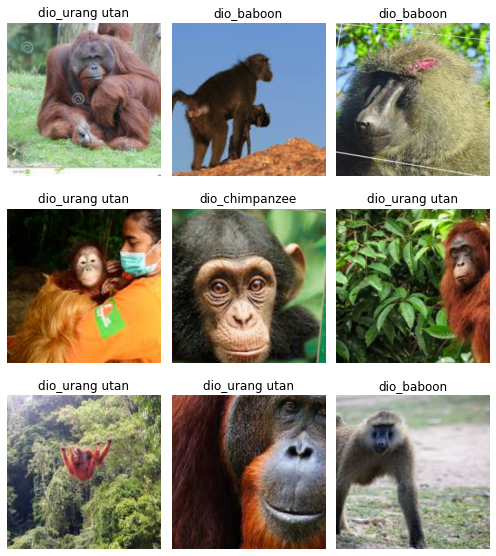

In [64]:
data.show_batch(rows=3, figsize=(7,8))